In [1]:
import torch
import os 
import uuid
import pandas as pd
import torch.nn.functional as F
from scripts.utils import load_model
from tqdm import tqdm

In [2]:
import re
import nltk
import spacy 

nlp_model = spacy.load('en_core_web_sm')

def find_sent_index(document, span):
    sentences = [sent.text for sent in nlp_model(document).sents]
    for sent_idx, sent in enumerate(sentences):
        if span in sent: 
            return sent_idx
            

def get_spacy_tokenization(doc):
    res_doc = nlp_model(doc)
    res_doc_tokens = [token.text for token in res_doc]
    res_doc_whitespaces = [token.whitespace_ for token in res_doc]
    res_doc_pos = [token.pos_ for token in res_doc]
    return res_doc_tokens, res_doc_whitespaces, res_doc_pos

def find_first_word_index(document, span):
    res_document_tokens, res_document_whitespaces, res_document_pos = get_spacy_tokenization(document)
    res_span_tokens, res_span_whitespaces, res_span_pos = get_spacy_tokenization(span)
    
    match_idx = -1
    for idx, doc_token in enumerate(res_document_tokens):
        if doc_token == res_span_tokens[0]:
            candidate_tokens = res_document_tokens[idx : idx + len(res_span_tokens)]
            candidate_whitespace = res_document_whitespaces[idx: idx + len(res_span_tokens)]
            candidate_span = ''.join([tok + spc for tok, spc in list(zip(candidate_tokens, candidate_whitespace))])
#             print(candidate_span)
            if candidate_span == span:
                match_idx = idx
                break
    pos_prefix = None
    if match_idx != -1:         
        pos_prefix = '_'.join(res_document_pos[match_idx-2 : match_idx + 1])
    return match_idx, pos_prefix
    

def append_row(df,
               append_dict):
    for column_key, column_val in append_dict.items():
        df[column_key] += [column_val]
    return df
               

def make_data_statistics(df_usb):
    hallucination_word_idx = []
    hallucination_sent_idx = []
    hallucination_pos_percent = []
    hallucination_count = []
    doc_length = []

    df_analysis = {
        'source': [],
        'summary': [],
        'model': [],
        'origin': [],
        'nonfactual_span': [],
        'hallucination_count': [],
        'hallucination_spn_idx': [],
        'hallucination_word_idx': [],
        'hallucination_pos_perc': [],
        'hallucination_sent_idx': [],
        'hallucination_sent_perc': [],
        'hallucinaton_prefix': [],
        'doc_length': [],
    }
    
    
    for idx, row in df_usb.iterrows():
        append_dict = {k : None for k in df_analysis.keys()}
        source = row['source']
        summ = row['summary']
        append_dict['source'] = source
        append_dict['summary'] = summ
        append_dict['model'] = row['model']
        append_dict['origin'] = row['origin']
        
        doc_length = len(re.findall(r'\b\w+\b', source))
        append_dict['doc_length'] = doc_length
        annotated_spans = row['annotated_spans'].split('<sep>') if type(row['annotated_spans']) is str else []
        # print(len(annotated_spans))
        
        if not annotated_spans:
            append_dict['hallucination_count'] = 0
            df_analysis = append_row(df_analysis, append_dict)
            
        else:
            for spn_idx, spn in enumerate(annotated_spans):
                # print(spn, summ)
                spn_summ_word_idx, spn_pos_prefix = find_first_word_index(summ, spn)
                spn_summ_sent_idx = find_sent_index(summ, spn)
                if len(annotated_spans) == 0 and spn_idx >= 0:
                    print(annotated_spans)
                
                if spn_summ_word_idx > -1:
                    if (spn_summ_sent_idx == None):
                        print(spn_summ_word_idx, spn_summ_sent_idx)
                        print(spn)
                        print([sent.text for sent in nlp_model(summ).sents])
    
                    else:
                        spn_summ_pos_percent = spn_summ_word_idx/len(re.findall(r'\b\w+\b', summ))
                        spn_summ_sent_percent = spn_summ_sent_idx/len([sent.text for sent in nlp_model(summ).sents])
                        append_dict['nonfactual_span'] = spn
                        append_dict['hallucination_spn_idx'] = spn_idx
                        append_dict['hallucination_word_idx'] = spn_summ_word_idx
                        append_dict['hallucination_pos_perc'] = round(spn_summ_pos_percent * 100)
                        append_dict['hallucination_sent_idx'] = spn_summ_sent_idx
                        append_dict['hallucination_sent_perc'] = round(spn_summ_sent_percent * 100)
                        append_dict['hallucination_count'] = len(annotated_spans)
                        append_dict['hallucinaton_prefix'] = spn_pos_prefix

                        # if len(annotated_spans) == 1:
                            # print(append_dict)
                        df_analysis = append_row(df_analysis, append_dict)
                        
                        # df_analysis['hallucination_spn_idx'] += [spn_idx]
                        # df_analysis['hallucination_word_idx'] += [spn_summ_word_idx]
                        # df_analysis['hallucination_pos_perc'] += [round(spn_summ_pos_percent * 100)]
                        # df_analysis['hallucination_sent_idx'] += [spn_summ_sent_idx]
                        # df_analysis['hallucination_sent_perc'] += [round(spn_summ_sent_percent * 100)]
                        # df_analysis['hallucination_count'] += [len(annotated_spans)]
                        # df_analysis['hallucinaton_prefix'] += [spn_pos_prefix]
                        # df_analysis['doc_length'] += [doc_length]
    
    
    df_analysis = pd.DataFrame(df_analysis)
    return df_analysis

In [3]:
df_usb = pd.read_csv('/home/ramprasad.sa/probing_summarization_factuality/datasets/USB_annotations.csv')

print('MODELS', set(df_usb['model'].values))
print('DATASETS', set(df_usb['origin'].values))

### Decoder only models
df_usb = df_usb[df_usb['model'] != 'flanul2']
df_usb = df_usb[~df_usb['source'].isnull()]
df_usb.head()[:1]

MODELS {'llama7b', 'falcon7b', 'llama70b', 'flanul2', 'mistral7b'}
DATASETS {'ACIBENCH', 'XSUM'}


,Unnamed: 0,id,source,summary,annotated_spans,model,origin
1,1,Cynthia Lamanda#XSUM-34443723#1701418173:mistr...,The case against two men accused of stealing £...,The document discusses a case where two men fr...,NaN,mistral7b,XSUM


In [4]:
df_usb_analysis = make_data_statistics(df_usb)

127 None
and will
["The document discusses a patient's chronic lower back pain and their attempt to seek medical treatment..", "The doctor asks about the patient's medical history, symptoms, and attempts at physical therapy and pain medications..", 'The patient reports that the pain started after they moved furniture and feels like a sharp stabbing pain in their back with numbness and tingling in their right leg..', 'The patient also reports difficulty sitting and being comfortable..', 'The doctor performs a physical exam and orders an MRI, which reveals a herniated disk with nerve impingement..', 'The doctor recommends a spinal injection with a corticosteroid to reduce inflammation and relieve pain..', 'The patient is told that the procedure is relatively quick and common and', 'will']
127 None
and will
["The document discusses a patient's chronic lower back pain and their attempt to seek medical treatment..", "The doctor asks about the patient's medical history, symptoms, and attempt

In [5]:
set(df_usb_analysis['model'])

{'falcon7b', 'llama70b', 'llama7b', 'mistral7b'}

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_hist_positions(df, 
                        pos_key,
                       xlabel,
                       ylabel,
                       title):
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(13, 4))
    
    # Iterate over origins 
    for i, origin in enumerate(list(set(df['origin'].values))):
        df_origin = df[df['origin'] == origin]
        
        for j, model in enumerate(list(set(df['model'].values))):
            df_model = df_origin[df_origin['model'] == model]
        
        # Create histogram plot
            sns.histplot(df_model[pos_key], bins=10, kde=True, color='skyblue', ax=axes[i][j])
        
            # Add labels and title
            axes[i][j].set_xlabel(xlabel)
            axes[i][j].set_ylabel(ylabel)
            axes[i][j].set_title(f'{model}{origin}')
    
    # Adjust layout
    fig.suptitle(title)
    plt.tight_layout()
    
    # Show plots
    plt.show()

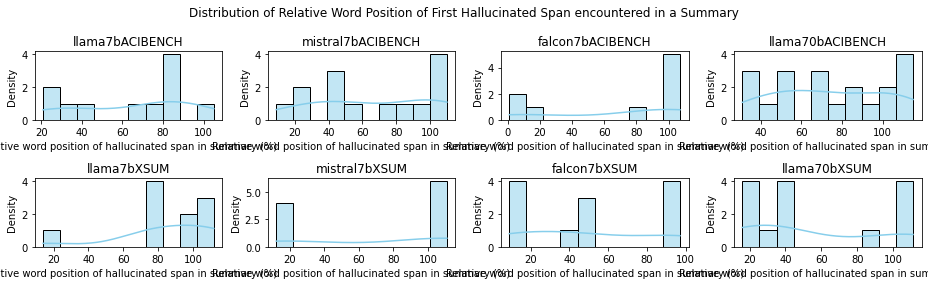

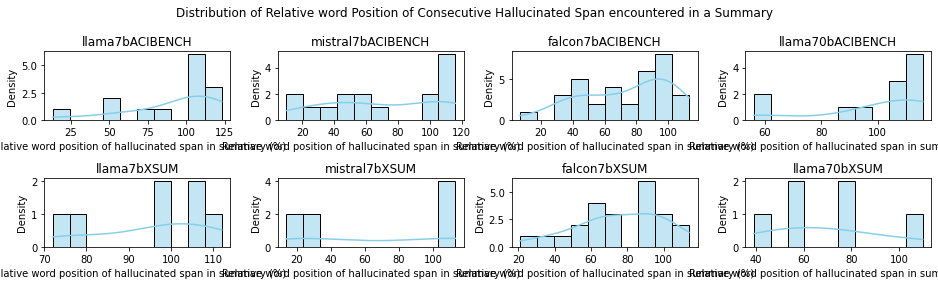

In [7]:
df_first_hallucination = df_usb_analysis[df_usb_analysis['hallucination_spn_idx'] == 0]

plot_hist_positions(df_first_hallucination,
                    pos_key = 'hallucination_pos_perc',
                    xlabel = 'Relative word position of hallucinated span in summary (%)',
                    ylabel = 'Density',
                    title = 'Distribution of Relative Word Position of First Hallucinated Span encountered in a Summary')

df_second_hallucination = df_usb_analysis[df_usb_analysis['hallucination_spn_idx'] > 0]

plot_hist_positions(df_second_hallucination,
                    pos_key = 'hallucination_pos_perc',
                    xlabel = 'Relative word position of hallucinated span in summary (%)',
                    ylabel = 'Density',
                    title = 'Distribution of Relative word Position of Consecutive Hallucinated Span encountered in a Summary')



# plot_hist_positions(df_first_hallucination,
#                     pos_key = 'hallucination_sent_perc',
#                     xlabel = 'Relative word position of hallucinated span in summary (%)',
#                     ylabel = 'Density',
#                     title = 'Distribution of Relative Sentence Position of First Hallucinated Span encountered in a Summary')



In [9]:
doc_length_boundary = [i for i in range(500, 1800, 500)]

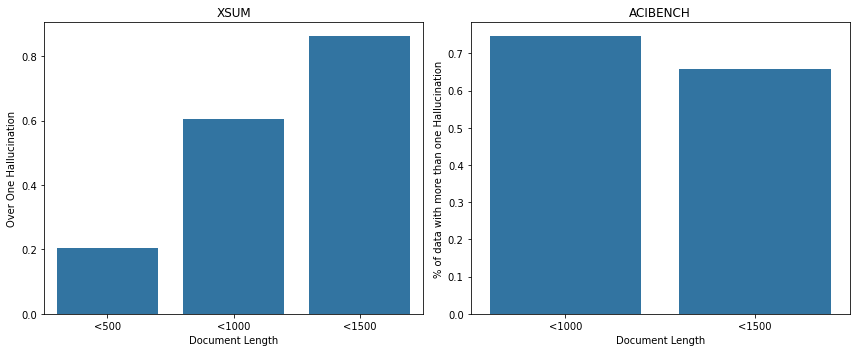

In [10]:
import numpy 
doc_length_stats = { 'doc_length': [],
                   'only_one_hallucination': [],
                   'origin': []}

### more chances of hallucination as doc length increases -- ? 

### 
for origin in list(set(df_usb_analysis['origin'])):
    df_origin = df_usb_analysis[df_usb_analysis['origin'] == origin]
    for idx, doc_boundary in enumerate(doc_length_boundary):
        df_analysis_docs = df_origin[df_origin['doc_length'] < doc_boundary]
        if len(df_analysis_docs) > 0:
            # print(df_analysis_docs)
            if idx > 0:
                df_analysis_docs = df_analysis_docs[df_analysis_docs['doc_length'] > doc_length_boundary[idx - 1]]
            df_analysis_docs_hallu = [each for each in df_analysis_docs['hallucination_count'].values if each > 0]
    
            
            hallucination_occured = len(df_analysis_docs_hallu)/len(df_analysis_docs['hallucination_count'].values) 
            doc_length_stats['doc_length'] += [f'<{doc_boundary}']
            doc_length_stats['only_one_hallucination'] += [hallucination_occured]
            doc_length_stats['origin'] += [origin]           
                                      

doc_length_stats = pd.DataFrame(doc_length_stats)
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
categories = ['A', 'B', 'C', 'D', 'E']
values = [10, 20, 15, 25, 30]
doc_length_stats_xsum = doc_length_stats[doc_length_stats['origin'] == 'XSUM']
doc_length_stats_acibench = doc_length_stats[doc_length_stats['origin'] == 'ACIBENCH']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 - XSUM
sns.barplot(x=doc_length_stats_xsum['doc_length'], y=doc_length_stats_xsum['only_one_hallucination'], ax=axes[0])
axes[0].set_xlabel('Document Length')
axes[0].set_ylabel('Over One Hallucination')
axes[0].set_title('XSUM')

# Subplot 2 - ACIBENCH
sns.barplot(x=doc_length_stats_acibench['doc_length'], y=doc_length_stats_acibench['only_one_hallucination'], ax=axes[1])
axes[1].set_xlabel('Document Length')
axes[1].set_ylabel('% of data with more than one Hallucination')
axes[1].set_title('ACIBENCH')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


In [11]:
df_usb_analysis

,source,summary,model,origin,nonfactual_span,hallucination_count,hallucination_spn_idx,hallucination_word_idx,hallucination_pos_perc,hallucination_sent_idx,hallucination_sent_perc,hallucinaton_prefix,doc_length
0,The case against two men accused of stealing £...,The document discusses a case where two men fr...,mistral7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,76
1,The case against two men accused of stealing £...,"On 17 June, a trailer containing biscuits wort...",falcon7b,XSUM,the same day,1,0.0,36.0,97.0,1.0,50.0,NOUN_ADP_DET,76
2,The case against two men accused of stealing £...,The case against two men accused of stealing £...,llama7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,76
3,The case against two men accused of stealing £...,"Two men accused of stealing £20,000 worth of b...",llama70b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,76
4,[doctor] so tyler is a 56 -year-old male who p...,Tyler is a 56-year-old male with a past medica...,mistral7b,ACIBENCH,and it is more difficult to swallow them,1,0.0,49.0,45.0,2.0,29.0,NOUN_PUNCT_CCONJ,1494
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,League Two side Crewe Alexandra have signed de...,League Two side Crewe Alexandra have signed de...,falcon7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,106
412,League Two side Crewe Alexandra have signed de...,Crewe Alexandra has signed defender Eddie Nola...,mistral7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,106
413,Super League newcomers Leigh Centurions have s...,Leigh Centurions have signed Hull FC utility b...,llama7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,84
414,Super League newcomers Leigh Centurions have s...,"Leigh Centurions, newcomers to the Super Leagu...",mistral7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,84


In [12]:
df_usb_analysis['part_of_speech'] =[each.split('_')[-1] if each else None for each in df_usb_analysis['hallucinaton_prefix']]
df_usb_analysis.head()[:1]

,source,summary,model,origin,nonfactual_span,hallucination_count,hallucination_spn_idx,hallucination_word_idx,hallucination_pos_perc,hallucination_sent_idx,hallucination_sent_perc,hallucinaton_prefix,doc_length,part_of_speech
0,The case against two men accused of stealing £...,The document discusses a case where two men fr...,mistral7b,XSUM,None,0,NaN,NaN,NaN,NaN,NaN,None,76,None


<Axes: xlabel='part_of_speech', ylabel='Count'>

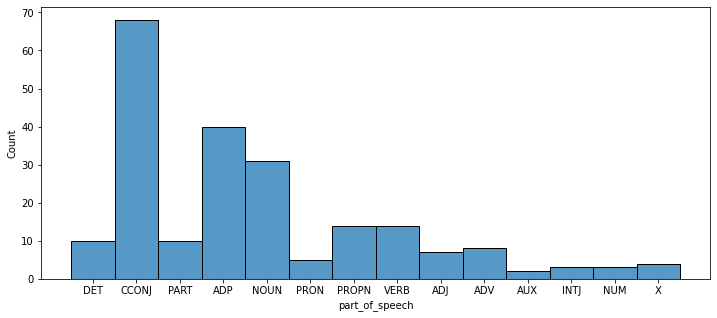

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pos_plots= df_usb_analysis[df_usb_analysis['part_of_speech'] != None]
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
df_xsum = df_pos_plots[df_pos_plots['origin'] == 'XSUM']
sns.histplot(df_pos_plots['part_of_speech'], axes = axes)

<Axes: xlabel='part_of_speech', ylabel='Count'>

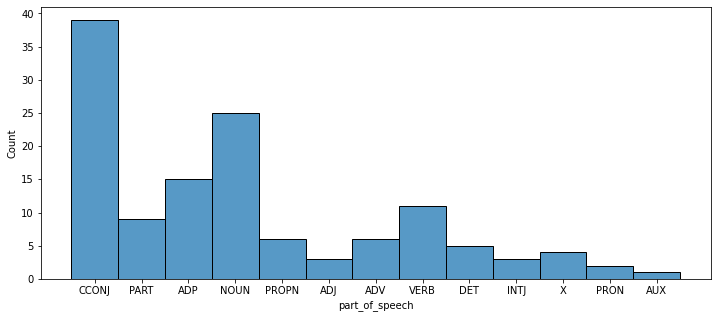

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt


### first pos of hallucinating span 
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
df_aci = df_pos_plots[df_pos_plots['origin'] == 'ACIBENCH']
sns.histplot(df_xsum['part_of_speech'], axes = axes)

In [311]:
df_aci

,source,summary,model,origin,nonfactual_span,hallucination_count,hallucination_spn_idx,hallucination_word_idx,hallucination_pos_perc,hallucination_sent_idx,hallucination_sent_perc,hallucinaton_prefix,doc_length,part_of_speech
4,[doctor] so tyler is a 56 -year-old male who p...,Tyler is a 56-year-old male with a past medica...,mistral7b,ACIBENCH,and it is more difficult to swallow them,1,0.0,49.0,45.0,2.0,29.0,NOUN_PUNCT_CCONJ,1494,CCONJ
5,[doctor] so tyler is a 56 -year-old male who p...,"The patient, Tyler, is a 56-year-old male who ...",llama7b,ACIBENCH,to confirm the diagnosis,1,0.0,88.0,85.0,3.0,60.0,DET_NOUN_PART,1494,PART
6,[doctor] so tyler is a 56 -year-old male who p...,"A 56-year-old male patient, Tyler, presented t...",llama70b,ACIBENCH,to diagnose the cause of the patient's symptoms,2,0.0,33.0,31.0,1.0,17.0,DET_NOUN_PART,1494,PART
7,[doctor] so tyler is a 56 -year-old male who p...,"A 56-year-old male patient, Tyler, presented t...",llama70b,ACIBENCH,for his,2,1.0,115.0,108.0,5.0,83.0,VERB_PROPN_ADP,1494,ADP
8,[doctor] hey hi bobby how are you doing. [pati...,The patient is experiencing shoulder pain that...,llama7b,ACIBENCH,None,0,NaN,NaN,NaN,NaN,NaN,None,1098,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,[doctor] hi jacqueline how are you doing today...,"The doctor is examining a patient, Jacqueline,...",llama7b,ACIBENCH,smoking,2,0.0,34.0,31.0,1.0,20.0,NOUN_CCONJ_NOUN,1052,NOUN
402,[doctor] hi jacqueline how are you doing today...,"The doctor is examining a patient, Jacqueline,...",llama7b,ACIBENCH,and,2,1.0,117.0,107.0,1.0,20.0,AUX_ADJ_CCONJ,1052,CCONJ
403,[doctor] hello larry how are you doing today. ...,"The patient, Larry, is experiencing chronic ba...",llama7b,ACIBENCH,None,0,NaN,NaN,NaN,NaN,NaN,None,1035,None
404,[doctor] hello larry how are you doing today. ...,The patient has a history of chronic back pain...,falcon7b,ACIBENCH,None,0,NaN,NaN,NaN,NaN,NaN,None,1035,None
